# Rate Limiting and the Companies House API

__Alistair Boyer__

[Companies House](https://www.gov.uk/government/organisations/companies-house/about) keeps the records for all registered companies in the UK. It evolved from the first [national register of companies in 1844](https://en.wikipedia.org/wiki/Companies_House) and currently operates within the Department for Business and Trade within the UK Government. Companies House incorporates and dissolves companies and makes these details available to the public. The records kept include a unique company number, a unique company name, the type of company, address details, details of significant people such as directors; and reports about insolvency, significant debts (charges) and finances in general. These details are available to the public through the Companies House API.

As with most modern APIs and web servers, the number of requests is rate-limited. Rate-limiting is implemented to protect against [malicious attacks](https://en.wikipedia.org/wiki/Denial-of-service_attack) and to ensure a good service for all users. If you don't adhere to the rate limits you risk being banned. This article discusses different strategies for implementing a rate limit. 


### Contents:
1. Setting up Companies House API Access
1. Using secure API keys in python with the `dotenv` package
1. Using a `requests.Session` to persist data over multiple requests
1. Strategies for implementing a rate limit
1. Using the companies house API

## Setting Up API Access

Companies House has provided [clear instructions](https://developer.company-information.service.gov.uk/how-to-create-an-application) on setting up their API.

1. The first step is to navigate to https://developer.company-information.service.gov.uk/manage-applications. You will have to sign in to access the page - you can register an account for free.
1. Then an application can be created by clicking on the “Create and application” button. Application name and description are self explanatory and the test vs live choice help manage multiple API keys. Optionally, you can add details about terms and conditions and a privacy policy.
1. Once an application is created, the application should appear on the "Manage Applications" page and you can click on the application to edit and add new API keys. 
1. Add a new API key - this needs a name and description. You can also choose between REST, Stream and Web types. This page will use a REST Api key. You can restrict requests by IP address for added security.
1. Within the application management page they API key should now be visible.

![API Setup Steps](./images/CompaniesHouseAPISetup.png)




## Top Secret

API keys should be treated as secure data same as passwords. They should never be used plain in code, even for a short time, because if you accidentally publish that code online then the key is available for everyone to see. One way to manage this kind of secret information is to store the information in a `.env` file. These files are recognised to contain environment information that should not be replicated. For example, `.env` is included as part of github's `.gitignore` [template](https://github.com/github/gitignore/blob/4488915eec0b3a45b5c63ead28f286819c0917de/Python.gitignore#L123).

The `.env` file is a plain text file with one `key=value` pair on each line, where the key and value are separated by an equals character ("="). To include the companies house API key in the `.env` file, a line with suitable name (e.g. "companies_house_api") and the API key can be added as demonstrated below. If there is already a `.env` file, the key can be added on a separate line to the other information or a new file can be created in the same folder as the project.

Example `.env` plain text file:

Then to use the values in python you can exploit the [dotenv package](https://pypi.org/project/python-dotenv/](https://pypi.org/project/python-dotenv/). The `dotenv` package has a function `dotenv_values` that opens a file and returns the contents as an ordered dictionary. Then you can access your API key using the name you used above, for example:

In [1]:
import dotenv

# get value from .env file
companies_house_api_key = dotenv.dotenv_values(".env")["companies_house_api"]

## Setting Up a Session

To get data from Companies House you can use a `GET` request constructed with the relevant information.
Performing an API request requires the communication of your API key with every request. The best way to persist information, such as authentication or cookie data, across multiple requests is use a [`requests.Session`](https://requests.readthedocs.io/en/latest/user/advanced/). 
`requests.Session` objects have all the functionality of normal requests functions but with added bonuses that include persistence of information and connection pooling. 
A `COMPANIES_SESSION` can be created by calling the class instancer, then the API Key can be saved into the `.auth` property. The value for `.auth` is a `HTTPBasicAuth('user', 'pass')` that will be generated automatically from a `tuple('user', 'pass')`. For companies house, the username is the API key and the password is an empty str.

In [2]:
import requests

# The Session object allows you to persist information across requests. 
COMPANIES_SESSION = requests.Session()

# The API Key information can be stored in the session
COMPANIES_SESSION.auth = (dotenv.dotenv_values(".env")["companies_house_api"], "")

## Not So Fast! Rate Limiting the Requests

To preserve the integrity of the service for all users, the Companies House API implements a rate limit for requests. The [developer guidelines](https://developer-specs.company-information.service.gov.uk/guides/rateLimiting) state that there can be a maximum of __600 requests within a 5 minute period__. If this is exceeded, a request will result in a `429 Too Many Requests` HTTP response. To comply with this rate limit, there are various different strategies.

In [3]:
COMPANIES_HOUSE_REQUEST_NUMBER = 600
COMPANIES_HOUSE_REQUEST_TIME = 5 * 60  # s

### Constant Delay

First, an (at least) $ \frac{5 \times 60}{600} = 0.5\text{ s} $ delay can be added between every request. This could be done by creating a wrapper function to the `COMPANIES_SESSION` that was initialised above. The function `companies_house_get_minimum_period()` passes all supplied arguments to the `COMPANIES_SESSION.get()` method __but__ only after waiting the minimum period. 

To implement the waiting, the time of the last request needs to be tracked so can be stored in a _global_ variable `_companies_house_last_get`. This variable is global so that it won't be rewritten with every function call; and is initialised to a date sufficiently in the past (here the date of the moon-landing!). To modify `_companies_house_last_get` inside `companies_house_get` it needs defining to be in global scope using the `global` keyword. Then the time since the last request can be calculated compared with the current time: `datetime.datetime.now()` using subtraction. The subtraction of two `datetime.datetime` objects returns a `datetime.timedelta` object and the total seconds difference can be calculated by calling its `.total_seconds()` method. If the time since the last request is less than the minimum time `_companies_house_period` then `time.sleep()` can be used to wait for an appropriate amount of time. Finally, `_companies_house_last_get` needs updating to the current time (N.B. after waiting) to reflect the current request. Finally, the result of the request can be returned.

In [4]:
import time
import datetime

_companies_house_last_get = datetime.datetime.fromisoformat('1969-07-20')  # moon landing!
_companies_house_period = COMPANIES_HOUSE_REQUEST_TIME / COMPANIES_HOUSE_REQUEST_NUMBER  # period

def companies_house_get_minimum_period(*args, **kwargs):
    """A rate limited function for performing a GET request,
    rate-limited with a minimum period."""
    
    # bring global variables into this scope
    global _companies_house_last_get
    
    # colculate the timedelta and get its total seconds
    time_since_last_request = (datetime.datetime.now() - _companies_house_last_get).total_seconds()
    
    # if the time is too short then sleep
    if time_since_last_request < _companies_house_period:
        time.sleep(_companies_house_period - time_since_last_request)
        
    # update the time of last request
    _companies_house_last_get = datetime.datetime.now()
    
    # perform and return the last request
    return COMPANIES_SESSION.get(*args, **kwargs)

If there is a requirement for a large number of requests or continual requests then this a good approach because the rate limit is adhered to and the requests are distributed evenly over time. 

However, in other cases than this approach has a significant drawback. The specific text of the rate limitation is __600 requests within a 5 minute period__ that is a batch limit but the above approach implemented an average this rate limit. Using an average means that if there are 599 requests then the rate should only be limited by connection speed whereas an average-limit would make a minimum time of 5 minutes! 

### Request History

To overcome the problem that waiting a constant time adds a unnecessary delay in many applications, a function `companies_house_get_deque()` can be defined that implements a literal interpretation of the rate limit of "600 requests within a 5 minute period".  This function tracks the time of every request in a [double ended queue](https://docs.python.org/3/library/collections.html) (`collections.deque`).
The deque is initialised from a list of a single date suitably in the past
and the maximum length of the deque is set with `maxlen=` to be the number of requests.
Setting `maxlen=` means that the deque will be shortened to `maxlen - 1` by dropping items from the right before a new object is added. 

This time, the `deque` object is mutable so does not be to be declared within the global scope. 
The `time_since_oldest_request` is calculated by subtracting the oldest item in the `deque` (retrieved using the `[-1]` accessor)
from `datetime.datetime.now()` to give a `datetime.timedelta`. 
If the `.total_seconds()` of this timedelta is longer than the mandated amount then `time.sleep()` waits an appropriate amount of time.
Finally, the time of the current request is added to the `deque` and the request is performed and returned.

In [5]:
import collections

_companies_house_gets = collections.deque(
    [datetime.datetime.fromisoformat('1969-07-20')],  # single entry queue
    maxlen=COMPANIES_HOUSE_REQUEST_NUMBER,  # maximum length of dequeue
)

def companies_house_get_deque(*args, **kwargs):
    """A rate limited function for performing a GET request,
    rate-limited with history deque."""

    # colculate the timedelta and get its total seconds
    time_since_oldest_request = (datetime.datetime.now() - _companies_house_gets[-1]).total_seconds()
        
    # if the time is too short then sleep
    if COMPANIES_HOUSE_REQUEST_TIME > time_since_oldest_request:
        time.sleep(COMPANIES_HOUSE_REQUEST_TIME - time_since_oldest_request)
        
    # add the time of this request to the LEFT of the deque
    # this will push the oldest time out of RIGHT if there are more than maxlen=
    _companies_house_gets.appendleft(datetime.datetime.now())
    
    # perform and return the request
    return COMPANIES_SESSION.get(*args, **kwargs)

This is an approach that most accurately aligns with the defined rate limit but does has the overhead of keeping track of all the request times.

## Companies House API in Action

The Companies House API can be used to search for companies by name.
The [reference](https://developer-specs.company-information.service.gov.uk/companies-house-public-data-api/reference/search/search-companies)
describes the relevant API endpoint as https://api.company-information.service.gov.uk/search/companies and 
paramaters: `q=` search term, `items_per_page=` (max 100) and `start_index=` (must be a multiple of `items_per_page`).

A `company_response` can be generated using the `companies_house_get` function, with the endpoint URL and params supplied as arguments. 
A successful API request returns a response containing json-formatted content that can be parsed using the `.json()` method. 
The data content is in the `'items'` and this can be directly converted to a `pandas.DataFrame`.

If the `query = "Blobby"` is used then there are only 6 results so all the data is returned in a single request. Selected information has been displayed and a dictionary of the [different fields](https://developer-specs.company-information.service.gov.uk/companies-house-public-data-api/resources/companysearch) in the result is available.

In [6]:
import urllib
import pandas

query = "Blobby"

# perform request using rate limiting functions
company_response = companies_house_get_minimum_period(
    # API endpoint
    "https://api.company-information.service.gov.uk/search/companies",
    # API params
    params=dict(
        q=query,
        items_per_page=100,
        start_index=0,  # must be multiple of items_per_page
    ),
)

# convert response into dataframe
blobby = pandas.DataFrame(company_response.json()['items'])

# ouptut selected information
display(blobby[['company_number', 'title', 'company_status']])

,company_number,title,company_status
0,07407247,BLOBBY LTD,dissolved
1,08530132,BLOBBY WILLIAMS LTD,active
2,12101302,BLOBBY LANGUAGE SOLUTIONS LTD,dissolved
3,07279400,MR BLOBBY UNLIMITED,dissolved
4,13062788,BLOBBIES LTD,active
5,13621170,BLOBBIES COOKIES LTD,dissolved


With a small dataset all the results can be retrieved with a single request but if there are more than 100 results (or `items_per_page`) the data will split across several pages upto a limit of 1000 items for a single query. A `company_search()` function can be used to gather data from repeated requests until there is no more or the limit is reached. The function is set up with a choice of `getter=` so that the different getters from above can be compared. A `results` list is used to hold the data from the requests. The maximum number of results is 1000, that is 10 loops of 100 at a time. After the getter generates a `company_response`, the response is checked to make sure that is has content and a `200` status code, then the results can be parsed from the `.json()` method and the `items` added to the results list. Finally, the gathered results can be returned. 

In [7]:
def company_search(query, getter=companies_house_get_deque):
    """Execute a company query at Companies House."""
    
    # hold the results
    results = list()
    
    # maximum of 1000 results 10 * 100
    for _ in range(10):

        # perform request using rate limiting functions
        company_response = getter(
            # API endpoint
            "https://api.company-information.service.gov.uk/search/companies",
            # API params
            params=dict(
                q=query,
                items_per_page=100,
                start_index=len(results),  # must be multiple of items_per_page
            ),
        )

        # empty response
        if not company_response.content:
            break

        # error code
        if company_response.status_code != 200:
            break

        response_json = company_response.json()
            
        # update the results list
        results += response_json['items']

        # expected number of results check
        if len(results) >= response_json['total_results']:
            break

    return results

The search is performed by passing a search term into the function: `company_search("Banana")`. Having the `getter=` as an argument means that `companies_house_get` and `companies_house_get_deque` can be compared using `time.perf_counter()` to keep track of elapsed time. The number of "Banana" companies is much more than "Blobby" companies, returning 925 results. This means a total of 10 requests. The time taken for the two getters can be compared with an obvious cost of using the $0.5\text{ s}$ regulated getter, whereas the deque getter has no wait time at all, only limited by connection.

In [8]:
# load results for "Banana" with minimum period between each
start = time.perf_counter()
banana = company_search("Banana", getter=companies_house_get_minimum_period)
print(f"companies_house_get_minimum_period: {time.perf_counter()-start:.2f}")

# load results for "Banana" with tracked calls in a deque
start = time.perf_counter()
banana = company_search("Banana", getter=companies_house_get_deque)
print(f"companies_house_get_deque: {time.perf_counter()-start:.2f}")

companies_house_get_minimum_period: 4.66
companies_house_get_deque: 1.68


### Banana Companies

The Banana result list from the `company_search()` can be loaded directly into a pandas.DataFrame: `banana`. There are two datetime columns that should be converted: `'date_of_creation'`, `'date_of_cessation'`. Then a brief `.sample()` of 5 rows reveals the nature of the dataset. More information about the different fields is available from the [data dictionary](https://developer-specs.company-information.service.gov.uk/companies-house-public-data-api/resources/companysearch).

In [9]:
# convert list to dataframe
banana = pandas.DataFrame(banana)

# convert date to datetime
banana['date_of_creation'] = pandas.to_datetime(banana['date_of_creation'])
banana['date_of_cessation'] = pandas.to_datetime(banana['date_of_cessation'])

# display 5 random rows
display(banana.sample(5))

,kind,company_status,address_snippet,matches,snippet,description_identifier,description,links,date_of_creation,company_number,company_type,title,address,date_of_cessation,external_registration_number
795,searchresults#company,dissolved,"11 Blacksmith Drive, Bromsgrove, Worcestershi...","{'snippet': [], 'title': [6, 11]}",,[dissolved-on],08337155 - Dissolved on 24 May 2016,{'self': '/company/08337155'},2012-12-19,08337155,ltd,BENT BANANA LIMITED,"{'locality': 'Bromsgrove', 'country': 'England...",2016-05-24,NaN
572,searchresults#company,active,"4 Hillfield Close, Redhill, England, RH1 4AR","{'snippet': [], 'title': [8, 13]}",,[incorporated-on],12667449 - Incorporated on 12 June 2020,{'self': '/company/12667449'},2020-06-12,12667449,ltd,SECOND BANANA LTD,"{'locality': 'Redhill', 'premises': '4', 'addr...",NaT,NaN
739,searchresults#company,dissolved,"Kemp House, 152 City Road, London, England, EC...","{'snippet': [], 'title': [11, 16]}",,[dissolved-on],10652476 - Dissolved on 14 August 2018,{'self': '/company/10652476'},2017-03-04,10652476,ltd,CATCH THE BANANA LIMITED,"{'postal_code': 'EC1V 2NX', 'locality': 'Londo...",2018-08-14,NaN
274,searchresults#company,dissolved,"4 Westend Street, Oldham, England, OL9 6AJ","{'snippet': [], 'title': [1, 6]}",,[dissolved-on],09480247 - Dissolved on 5 December 2017,{'self': '/company/09480247'},2015-03-10,09480247,ltd,BANANA MOTORS OLDHAM LIMITED,"{'premises': '4 ', 'postal_code': 'OL9 6AJ', '...",2017-12-05,NaN
936,searchresults#company,dissolved,"18 West Street, Wareham, Dorset, BH20 4JX","{'title': [9, 14], 'snippet': []}",,[dissolved-on],05074993 - Dissolved on 8 June 2010,{'self': '/company/05074993'},2004-03-16,05074993,ltd,WILSONS BANANA FACTORY LIMITED,"{'address_line_2': 'Wareham', 'postal_code': '...",2010-06-08,NaN


---
The [wordcloud](https://amueller.github.io/word_cloud/) package allows the creation of wordclouds. 
Generating a wordcloud of the different company names (`'title'`) reveals a diverse range of banana-related companies.
The world cloud looks better if the company-related names: "Limited", "LTD", "PLC", "LLP" are removed that can be achieved by added them to the built in `wordcloud.STOPWORDS` set.

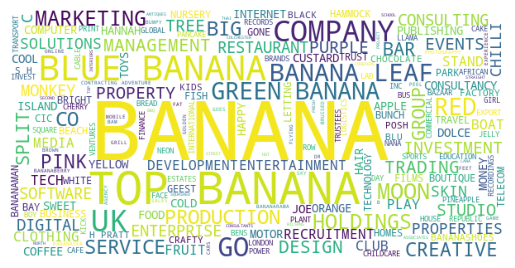

In [10]:
import wordcloud
import matplotlib.pyplot as plt

# initialise the WordCloud
wc = wordcloud.WordCloud(
    width=600,
    height=300,
    max_font_size=100,
    background_color="white",
    stopwords=wordcloud.STOPWORDS | {'limited', 'ltd', 'llp', 'plc'},
)

# generate the wordcloud
wc.generate("\n".join(banana['title']))

# show the wordcloud
plt.imshow(wc)
plt.axis("off")
plt.show()

---
There are four different statuses (out of the 10 [possible](https://developer-specs.company-information.service.gov.uk/companies-house-public-data-api/resources/companysearch)). The rows that have a non-null "date_of_cessation" have the associated status of dissolved.

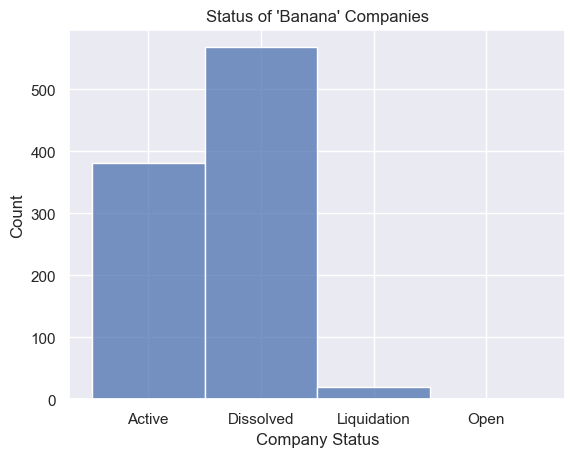

In [11]:
import seaborn
seaborn.set_theme()

fig, ax = plt.subplots()
seaborn.histplot(banana['company_status'], ax=ax)
ax.set(
    xlabel="Company Status",
    ylabel="Count",
    title="Status of 'Banana' Companies",
    # set xlabels to title case
    xticks=ax.get_xticks(), 
    xticklabels=[text.get_text().title() for text in ax.get_xticklabels()],
)
plt.show()

# dissolved companies all have a "data_of_cessation"
assert (banana.loc[banana['date_of_cessation'].notna(), 'company_status'] == 'dissolved').all()
assert not (banana.loc[banana['date_of_cessation'].isna(), 'company_status'] == 'dissolved').any()

---
- The average age of 'Banana' companies is 6.8 years, including both companies that are still active and dissolved.
- The oldest 'Banana' company is [Geest Shipping](https://www.geestline.com/history/) that has been in business since 1932.

In [12]:
import IPython


# mean age of companies
display(IPython.display.Markdown("__Mean 'Banana' Company Age__"))
display(
    (
         banana['date_of_cessation'].fillna(datetime.datetime.today())
         - banana['date_of_creation']
    ).mean().days / 365.2425
)


# oldest active company
display(IPython.display.Markdown("__Oldest Non-Dissolved Companies__"))
display(
    banana.loc[
        banana['date_of_cessation'].isna(),
        ['date_of_creation', 'title', 'snippet', 'company_status'],
    ]
    .sort_values('date_of_creation')
    .head(5)
)

__Mean 'Banana' Company Age__

6.762630307261614

__Oldest Non-Dissolved Companies__

,date_of_creation,title,snippet,company_status
951,1932-07-08,GEEST SHIPPING LIMITED,GEEST BANANAS,active
790,1959-09-23,S H PRATT GROUP LIMITED,S.H. PRATT & CO. (BANANAS),active
967,1959-11-11,CENTRAL FLOWER SALES (COVENTRY) LIMITED,BANANAS (COVENTRY),active
488,1976-10-12,FORRESTERS (BANANAS) LIMITED,,active
386,1978-02-14,BANANAMAN PRODUCTIONS LIMITED,,active


---
Considering a date range starting with the oldest `date_of_creation` and ending with the current year.
The counts of active companies can be collated in a dictionary `counts` for each of the years in this range. 
The counts for a given year is the sum of records where the `date_of_creation` is the same or older than the year in question 
AND either the `date_of_cessation` is null OR later or equal to the year in question. 

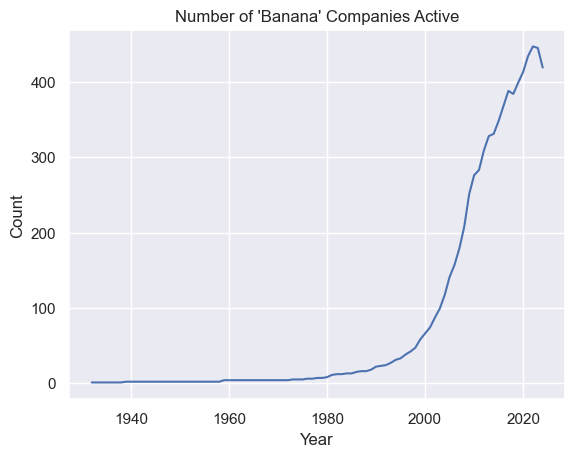

In [13]:
# date ranges
min_year = int(banana['date_of_creation'].dt.year.min())
max_year = datetime.datetime.today().year

# counts
counts = dict()

# consider each year in the range of interest
for year in range(min_year, max_year + 1):
    
    # the count for this year requires:
    counts[year] = (
        # company was created before or in the year
        (banana['date_of_creation'].dt.year <= year)
        # AND
        & (
            # company is still active
            banana['date_of_cessation'].isna()
            # OR company ceased after this year
            # also include this year otherwise companies that didn't see Christmas are not included
            | (banana['date_of_cessation'].dt.year >= year)
        )
    ).sum()

fig, ax = plt.subplots()
seaborn.lineplot(
    counts, 
    ax=ax,
)
ax.set(**dict(
    xlabel="Year",
    ylabel="Count",
    title="Number of 'Banana' Companies Active",
))
plt.show()

## Summary
Adhering to API rate-limits is an important consideration in the relationship between developers and platforms, enabling innovation while upholding integrity and efficiency. 
This article discussed how to setup an API key for Companies House; how to securely use the API key in python using `dotenv` and environment  a ".env" file; and to store the API key in a `requests.Session` object to persist the credential across multiple requests. 

A rate-limiting implementation for a GET request was demonstrated using either a constant wait time and a request history. This methodology was showcased in retrieving information about different companies by a name search on the companies house API. 

If you found this interesting, you could look further into rate limiting: consider how rate limiting can be implemented in general using decorators; investigate rate limiting packages on PyPI; or consider how the deque of calls could be saved or used across multiple applications.